In [ ]:
import random
import pandas as pd
import numpy as np
import torch
import os

In [5]:
paper_data = pd.read_csv('../Data/cleaned_data.csv')
paper_data = paper_data.set_index('time (UTC)')
paper_data['Time'] = paper_data.index.astype(int)
paper_data

,Avg_Chloro,Nitrate,Phosphate,Silicate,Nitrite,SURF_TEMP_C,BOT_TEMP_C,SURF_SAL_PSU,BOT_SAL_PSU,SURF_DENS_kgm3,BOT_DENS_kgm3,AVG_TEMP_C,AVG_SAL_PSU,AVG_DENS_kgm3,Time
time (UTC),,,,,,,,,,,,,,,
0.0,1.82,0.43,0.24,5.6,0.03,20.3,15.9,33.77,33.62,1023.638094,1024.620655,18.10,33.695,1024.129374,0
7.0,2.71,0.83,0.37,5.1,0.04,17.8,16.9,33.66,33.62,1024.186379,1024.391719,17.35,33.640,1024.289049,7
13.0,0.99,0.45,0.24,3.5,0.00,22.2,18.3,33.74,33.58,1023.100557,1024.026040,20.25,33.660,1023.563298,13
20.0,1.23,0.34,0.17,4.2,0.00,19.8,19.4,33.68,33.62,1023.701088,1023.780535,9.90,33.650,1023.740812,20
28.0,2.41,0.29,0.12,3.8,0.00,22.5,22.5,33.73,33.69,1023.009067,1023.000725,11.25,33.710,1023.004896,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5789.0,3.22,0.85,0.30,6.2,0.00,17.4,17.4,33.48,33.46,1024.146195,1024.152950,17.40,33.470,1024.149572,5789
5796.0,3.39,0.45,0.25,4.9,0.00,17.9,17.9,33.48,33.47,1024.026335,1024.040616,17.90,33.475,1024.033476,5796
5803.0,7.82,0.00,0.17,5.2,0.00,18.3,16.4,33.54,33.55,1023.974093,1024.454252,17.35,33.545,1024.214172,5803


In [6]:
def create_embeddings(data, E, tau, target=None):
    """
    Create time delay embeddings from time series data.
    
    Parameters:
    data (DataFrame): Input time series data where columns are features
    E (int): Maximum embedding dimension (number of time steps back)
    tau (int): Time delay between steps (absolute value will be used)
    target (str): Name of the target column in data
    
    Returns:
    X (list): List of embedded vectors, where each vector contains lagged values
    y (list): List of target values corresponding to each embedding
    """
    # Input validation
    if not isinstance(data, pd.DataFrame):
        raise TypeError("data must be a pandas DataFrame")
    if target not in data.columns:
        raise ValueError(f"target column '{target}' not found in data")
    if E < 1:
        raise ValueError("E must be at least 1")
    
    X = []
    y = []
    
    # Get the target column and ensure it's a numpy array
    target_values = data[target].values
    
    # Use absolute value of tau to ensure positive time delay
    tau = abs(tau)
    
    # Calculate the total length of history needed
    history_needed = (E - 1) * tau
    
    # Create embeddings for each viable time point
    for i in range(len(data)):
        # Skip points that don't have enough history
        if i < history_needed:
            continue
            
        # Create the embedding vector for this time point
        embedding = []
        
        # Add lagged values
        for e in range(E):
            # Calculate the index to look back to
            lag_idx = i - (e * tau)
            if lag_idx < 0:  # Safety check
                continue
            embedding.append(target_values[lag_idx])
        
        # Only add complete embeddings
        if len(embedding) == E:
            X.append(embedding)
            # Add the target value (next value in the series)
            if i < len(data) - 1 and (target is not None):  # Ensure we have a next value
                y.append(target_values[i + 1])
    
    # Convert to numpy arrays for convenience
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [7]:
X, y = create_embeddings(paper_data,3,-1,'Avg_Chloro')
X[0]

array([0.99, 2.71, 1.82])

In [13]:
def total_embeddings(data, E, tau, target):
    X, y = create_embeddings(data, E, tau, target)  

    result = X  

    for col in data.columns:
        if col != target:
            X_cur, _ = create_embeddings(data, E, tau, col)

            # Ensure all feature embeddings are properly stacked
            result = np.hstack((result, X_cur))  

    return result, y

In [11]:
E = 3
tau = -1
target = "Avg_Chloro"

X_emb, y_emb = total_embeddings(paper_data, E, tau, target)

In [16]:
X_emb[0], y_emb[0]

(array([9.90000000e-01, 2.71000000e+00, 1.82000000e+00, 4.50000000e-01,
        8.30000000e-01, 4.30000000e-01, 2.40000000e-01, 3.70000000e-01,
        2.40000000e-01, 3.50000000e+00, 5.10000000e+00, 5.60000000e+00,
        0.00000000e+00, 4.00000000e-02, 3.00000000e-02, 2.22000000e+01,
        1.78000000e+01, 2.03000000e+01, 1.83000000e+01, 1.69000000e+01,
        1.59000000e+01, 3.37400000e+01, 3.36600000e+01, 3.37700000e+01,
        3.35800000e+01, 3.36200000e+01, 3.36200000e+01, 1.02310056e+03,
        1.02418638e+03, 1.02363809e+03, 1.02402604e+03, 1.02439172e+03,
        1.02462065e+03, 2.02500000e+01, 1.73500000e+01, 1.81000000e+01,
        3.36600000e+01, 3.36400000e+01, 3.36950000e+01, 1.02356330e+03,
        1.02428905e+03, 1.02412937e+03, 1.30000000e+01, 7.00000000e+00,
        0.00000000e+00]),
 1.23)

In [44]:
from utils import get_data
from nn_edm import NNEDMModel
from HABs_dataset import HABsDataset
from train import train, eval
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
tau_lengths = [-1,-2,-3]
E = 6
target = 'Avg_Chloro'
X, y = get_data(paper_data, E, tau_lengths, target=target) #returns numpy arrays 
embd_sz = len(paper_data.columns) * E * len(tau_lengths)

In [120]:
X_tensor = torch.tensor(X, dtype=torch.float32)
X_mean = X_tensor.mean(dim=0, keepdim=True)
X_std = X_tensor.std(dim=0, keepdim=True)
X_tensor = (X_tensor - X_mean) / (X_std + 1e-8)  # Add small value to avoid division by zero

y_tensor = torch.tensor(y, dtype=torch.float32)
y_tensor = (y_tensor - y_tensor.mean()) / (y_tensor.std() + 1e-8)

In [121]:
print(f"Data processed: X shape {X_tensor.shape}, y shape {y_tensor.shape}")

Data processed: X shape torch.Size([817, 270]), y shape torch.Size([816])


In [122]:
# Train test split
len_data = len(y_tensor)
train_frac, val_frac, test_frac = 0.5, 0.3, 0.2  

train_size = int(train_frac * len_data)
val_size = int(val_frac * len_data)
test_size = len_data - train_size - val_size  

In [123]:
# Random seed
torch.manual_seed(0)
indices = torch.randperm(len_data)

In [124]:
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

In [125]:
X_train, y_train = X_tensor[train_indices], y_tensor[train_indices]
X_val, y_val = X_tensor[val_indices], y_tensor[val_indices]
X_test, y_test = X_tensor[test_indices], y_tensor[test_indices]

In [126]:
train_dataset = HABsDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = HABsDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = HABsDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embd_sz = X_tensor.shape[1]

In [139]:
model = NNEDMModel(embd_sz, hidden_size=100).to(device)

Finish epoch 0, time elapsed 0.01334691047668457
Loss at epoch: 0 is 0.3093560077250004
Finish epoch 100, time elapsed 0.005398988723754883
Loss at epoch: 100 is 0.2920171618461609
Finish epoch 200, time elapsed 0.005146026611328125
Loss at epoch: 200 is 0.2818685993552208
Finish epoch 300, time elapsed 0.004091978073120117
Loss at epoch: 300 is 0.27692584693431854
Finish epoch 400, time elapsed 0.016876697540283203
Loss at epoch: 400 is 0.27352432906627655
Finish epoch 500, time elapsed 0.0057218074798583984
Loss at epoch: 500 is 0.27138957008719444
Finish epoch 600, time elapsed 0.0044400691986083984
Loss at epoch: 600 is 0.26989633589982986
Finish epoch 700, time elapsed 0.00570988655090332
Loss at epoch: 700 is 0.2692127302289009
Finish epoch 800, time elapsed 0.003996849060058594
Loss at epoch: 800 is 0.26757510378956795
Finish epoch 900, time elapsed 0.007546901702880859
Loss at epoch: 900 is 0.26623252406716347


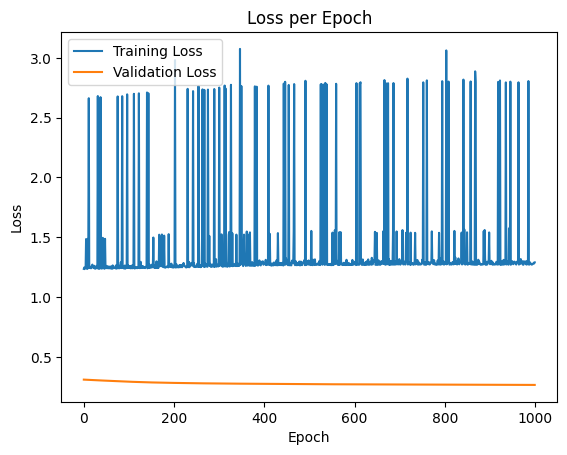

In [140]:
train(model=model,
      device=device,
      train_dataloader=train_dataloader,
      val_dataloader=val_dataloader)

In [141]:
eval(model=model,
     device=device,
     val_dataloader=test_dataloader)

Loss is 1.4036613702774048


1.4036613702774048

In [142]:
model.eval()
sample_inputs, sample_labels = next(iter(test_dataloader))  # Get a batch
sample_inputs = sample_inputs.to(device)
preds = model(sample_inputs).cpu().detach().numpy()

print("Predictions:", preds[:10])
print("Actual:", sample_labels[:10].numpy())

Predictions: [0.02355456 0.02355406 0.02355282 0.0235529  0.02355464 0.02355356
 0.02355438 0.02355226 0.02355421 0.02355392]
Actual: [ 0.215728   -0.3061799  -0.19145711 -0.24316314 -0.22538921  0.04606755
  0.08161546 -0.0751185  -0.39666548 -0.22215757]


In [143]:
for param in model.parameters():
    torch.nn.utils.clip_grad_norm_(param, max_norm=1.0)

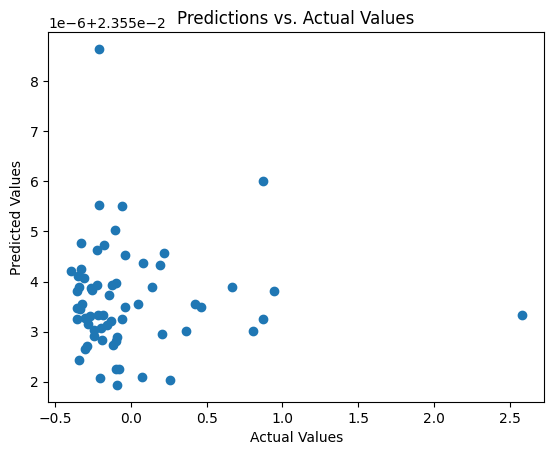

In [144]:
plt.scatter(sample_labels.numpy(), preds)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predictions vs. Actual Values")
plt.show()